# Default GloVe Model

- Glove 50d
- Optimizer : NAdam
- Batch Size = 128
- Learning Rate : 1e-4
- Epochs : 50
- Momentum : 0.8
- Weight Decay : 0.001


# GloVe Model with 1 Layer

**Layer Sizes**
- H1 = 64

- Glove 50d
- Optimizer : NAdam
- Batch Size = 64
- Learning Rate : 1e-4
- Epochs : 50


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


/var/folders/v9/0g473_2s1_7d8mjnpg8tx86r0000gn/T/ipykernel_1399/2251151274.py:76: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  x_train = torch.tensor(x_train['tweet'],dtype=torch.float)



Epoch:   0
(Training) - Loss = 1.34544
(Training) - F1 Score = 0.41422
(Validation) - Loss = 1.03884
(Validation) - F1 Score = 0.48066

Epoch:   1
(Training) - Loss = 0.99600
(Training) - F1 Score = 0.50483
(Validation) - Loss = 0.98087
(Validation) - F1 Score = 0.51069

Epoch:   2
(Training) - Loss = 0.95470
(Training) - F1 Score = 0.52497
(Validation) - Loss = 0.94700
(Validation) - F1 Score = 0.51912

Epoch:   3
(Training) - Loss = 0.92899
(Training) - F1 Score = 0.54056
(Validation) - Loss = 0.92478
(Validation) - F1 Score = 0.53731

Epoch:   4
(Training) - Loss = 0.91062
(Training) - F1 Score = 0.54984
(Validation) - Loss = 0.91221
(Validation) - F1 Score = 0.54282

Epoch:   5
(Training) - Loss = 0.89739
(Training) - F1 Score = 0.55808
(Validation) - Loss = 0.90127
(Validation) - F1 Score = 0.54025

Epoch:   6
(Training) - Loss = 0.88710
(Training) - F1 Score = 0.56381
(Validation) - Loss = 0.89262
(Validation) - F1 Score = 0.54274

Epoch:   7
(Training) - Loss = 0.87940
(Trainin

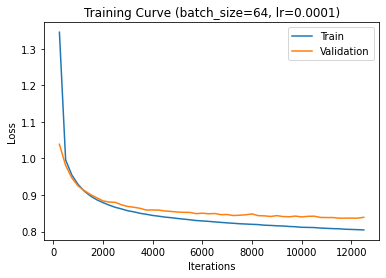

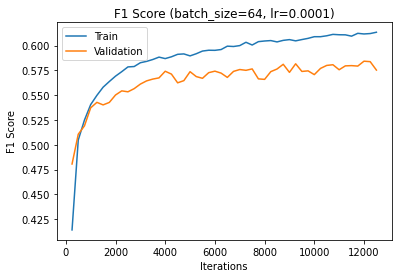

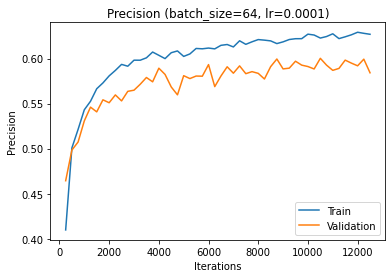

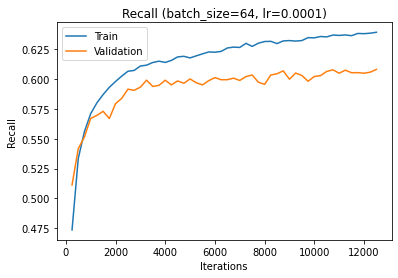

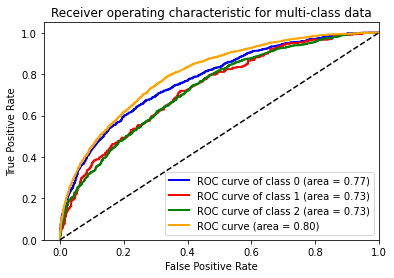

In [ ]:
#download glove dataset
!test -f glove.6B.50d.txt ||  ( wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip && unzip glove.6B.zip)
#download adabound
!pip3 install adabound

import re
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import nltk 
import re

from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.feature_extraction.text import  HashingVectorizer
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from numpy.ma.core import concatenate
from itertools import cycle
from adabound import AdaBound



glove = pd.read_csv('glove.6b.50d.txt', sep=' ', index_col=0, header=None, quoting=3)
glove_embedding = {key: val.values for key, val in glove.T.items()}



data_train = pd.read_csv('./vaccine_train_set.csv')
data_val = pd.read_csv('./vaccine_validation_set.csv')

x_train = pd.DataFrame(data_train,columns=[data_train.columns[1]])
y_train = pd.DataFrame(data_train,columns=[data_train.columns[2]])

x_val =  pd.DataFrame(data_val,columns=[data_val.columns[1]])
y_val =  pd.DataFrame(data_val,columns=[data_val.columns[2]])

def create_array(tweet): #split tweet into array of its words
    return re.split(' ',tweet)

def transform(tweet):
    array = np.array(np.zeros([1,50]))
    for word in tweet:
        if word not in glove_embedding: #glove does not contain the word in the tweet, fill features with 0
            ar = np.zeros([1,50])
        else:
            ar = np.array([glove_embedding.get(word)]) #fill row features with glove's word embedding
        array = np.concatenate((array,ar)) #concatenate the word embedding with the tweet embedding
    return array

def sum_array(tweet): #sum the array of word embeddings to get the tweet embedding
    return np.sum(tweet, axis=0) 



#create,transform,sum the tweet embedding
#train set
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:create_array(tweet))
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:transform(tweet))
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:sum_array(tweet))

#validation set
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:create_array(tweet))
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:transform(tweet))
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:sum_array(tweet))



#create the train tensor 
x_train = torch.tensor(x_train['tweet'],dtype=torch.float)
k_train = np.array(y_train['label'])

y_train = torch.from_numpy(k_train)
# y_train = y_train.to(torch.long)

#create the validation tensor 
x_val = torch.tensor(x_val['tweet'],dtype=torch.float)
k_val = np.array(y_val['label'])

y_val = torch.from_numpy(k_val)



#Define the NN

class Net(nn.Module):
    def __init__(self, D_in, H1, D_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, D_out)

        self.dropout = nn.Dropout(0.7)
        
    def forward(self, x):
        h1 = self.linear1(x)
        act1 =  nn.functional.relu(h1)

        out = self.linear2(act1)
        return out

#Define layer sizes
D_in = x_train.shape[1]
H1 = 64
D_out = 3

#Define Hyperparameters
learning_rate = 0.0001

#Initialize model, loss, optimizer
model = Net(D_in, H1, D_out)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)

#Initialize train dataloader
batch_size = 64
dataset_train = torch.utils.data.TensorDataset(x_train, y_train)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size, shuffle=True)


#Initialize validation dataloader
dataset_val = torch.utils.data.TensorDataset(x_val,y_val)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size, shuffle=True)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


iterations,losses_train,losses_val,f1ScoresTrain,f1ScoresVal,recallTrain,recallVal,precisionTrain,precisionVal = [],[],[],[],[],[],[],[],[]
n = 0
for epoch in range(50):
  batch_losses_train = []
  batch_losses_val = []
  f1_batch_scores_train,f1_batch_scores_val = [],[]
  precision_batch_train,precision_batch_val = [],[]
  recall_batch_train,recall_batch_val = [],[]

  for x_batch, y_batch in dataloader_train:
    y_pred_train = model(x_batch)
    loss = loss_func(y_pred_train, y_batch)
    batch_losses_train.append(loss.item())

    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()
    n += 1

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_train,dim=1)
    y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_batch,y_pred,average='weighted')
    precision = metrics.precision_score(y_batch,y_pred,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_batch,y_pred,average='weighted',zero_division=0)
    f1_batch_scores_train.append(f1Score)
    precision_batch_train.append(precision)
    recall_batch_train.append(recall)
  
  print(f'\nEpoch: {epoch:3}')
  print(f"(Training) - Loss = {sum(batch_losses_train)/len(dataloader_train):.5f}")
  print(f"(Training) - F1 Score = {sum(f1_batch_scores_train)/len(dataloader_train):.5f}")


  losses_train.append(sum(batch_losses_train)/len(dataloader_train))
  f1ScoresTrain.append(sum(f1_batch_scores_train)/len(dataloader_train))
  precisionTrain.append(sum(precision_batch_train)/len(dataloader_train))
  recallTrain.append(sum(recall_batch_train)/len(dataloader_train))
    

  #evaluate the model on the validation set
  for x_batch,y_batch in dataloader_val:
    y_pred_val = model(x_batch)
    loss_val = loss_func(y_pred_val,y_batch)
    batch_losses_val.append(loss_val.item())

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_val,dim=1)
    y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_batch,y_pred,average='weighted' )
    precision = metrics.precision_score(y_batch,y_pred,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_batch,y_pred,average='weighted',zero_division=0)
    f1_batch_scores_val.append(f1Score)
    precision_batch_val.append(precision)
    recall_batch_val.append(recall)

  losses_val.append(sum(batch_losses_val)/len(dataloader_val))
  f1ScoresVal.append(sum(f1_batch_scores_val)/len(dataloader_val))
  precisionVal.append(sum(precision_batch_val)/len(dataloader_val))
  recallVal.append(sum(recall_batch_val)/len(dataloader_val))

  print(f"(Validation) - Loss = {sum(batch_losses_val)/len(dataloader_val):.5f}")
  print(f"(Validation) - F1 Score = {sum(f1_batch_scores_val)/len(dataloader_val):.5f}")

  iterations.append(n)
  # scheduler.step()



# Plotting

#Loss
plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, losses_train, label="Train")
plt.plot(iterations, losses_val, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

#F1 Score
plt.title("F1 Score (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, f1ScoresTrain, label="Train")
plt.plot(iterations, f1ScoresVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

#Precision
plt.title("Precision (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, precisionTrain, label="Train")
plt.plot(iterations, precisionVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Precision")
plt.legend(loc='best')
plt.show()

#recall
plt.title("Recall (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, recallTrain, label="Train")
plt.plot(iterations, recallVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Recall")
plt.legend(loc='best')
plt.show()


#roc curve
y_val_roc = label_binarize(y_val, classes=[0, 1, 2])
fpr = dict()
tpr = dict()
roc_auc = dict()
y_val_roc = torch.tensor(y_val_roc)

y_pred_val = model(x_val)
sc = nn.functional.softmax(y_pred_val,dim=1)

for i in range(3):
  fpr[i], tpr[i], _ = roc_curve(y_val_roc.detach().numpy()[:, i], sc.detach().numpy()[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

fpr[3], tpr[3], _ = roc_curve(y_val_roc.detach().numpy().ravel(), sc.detach().numpy().ravel())
roc_auc[3] = auc(fpr[3], tpr[3])

colors = cycle(['blue', 'red', 'green','orange'])
for i, color in zip(range(4), colors):
  if(i == 3):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve (area = {0:0.2f})'
             ''.format(roc_auc[i]))
  else:
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


In [3]:
#download glove dataset
!test -f glove.6B.50d.txt ||  ( wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip && unzip glove.6B.zip)
#download adabound
!pip3 install adabound

import re
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import nltk 
import re

from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.feature_extraction.text import  HashingVectorizer
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from numpy.ma.core import concatenate
from itertools import cycle
from adabound import AdaBound



glove = pd.read_csv('glove.6b.50d.txt', sep=' ', index_col=0, header=None, quoting=3)
glove_embedding = {key: val.values for key, val in glove.T.items()}



data_train = pd.read_csv('./vaccine_train_set.csv')
data_val = pd.read_csv('./vaccine_validation_set.csv')

x_train = pd.DataFrame(data_train,columns=[data_train.columns[1]])
y_train = pd.DataFrame(data_train,columns=[data_train.columns[2]])

x_val =  pd.DataFrame(data_val,columns=[data_val.columns[1]])
y_val =  pd.DataFrame(data_val,columns=[data_val.columns[2]])

def create_array(tweet): #split tweet into array of its words
    return re.split(' ',tweet)

def transform(tweet):
    array = np.array(np.zeros([1,50]))
    for word in tweet:
        if word not in glove_embedding: #glove does not contain the word in the tweet, fill features with 0
            ar = np.zeros([1,50])
        else:
            ar = np.array([glove_embedding.get(word)]) #fill row features with glove's word embedding
        array = np.concatenate((array,ar)) #concatenate the word embedding with the tweet embedding
    return array

def sum_array(tweet): #sum the array of word embeddings to get the tweet embedding
    return np.sum(tweet, axis=0) 



#create,transform,sum the tweet embedding
#train set
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:create_array(tweet))
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:transform(tweet))
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:sum_array(tweet))

#validation set
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:create_array(tweet))
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:transform(tweet))
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:sum_array(tweet))



#create the train tensor 
x_train = torch.tensor(x_train['tweet'],dtype=torch.float)
k_train = np.array(y_train['label'])

y_train = torch.from_numpy(k_train)
# y_train = y_train.to(torch.long)

#create the validation tensor 
x_val = torch.tensor(x_val['tweet'],dtype=torch.float)
k_val = np.array(y_val['label'])

y_val = torch.from_numpy(k_val)



#Define the NN

class Net(nn.Module):
    def __init__(self, D_in, H1, D_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, D_out)

        self.dropout = nn.Dropout(0.7)
        
    def forward(self, x):
        h1 = self.linear1(x)
        act1 =  nn.functional.relu(h1)

        out = self.linear2(act1)
        return out

#Define layer sizes
D_in = x_train.shape[1]
H1 = 64
D_out = 3

#Define Hyperparameters
learning_rate = 0.0001

#Initialize model, loss, optimizer
model = Net(D_in, H1, D_out)
loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)


#Initialize train dataloader
batch_size = 128
dataset_train = torch.utils.data.TensorDataset(x_train, y_train)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size, shuffle=True)


#Initialize validation dataloader
dataset_val = torch.utils.data.TensorDataset(x_val,y_val)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size, shuffle=True)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


iterations,losses_train,losses_val,f1ScoresTrain,f1ScoresVal,recallTrain,recallVal,precisionTrain,precisionVal = [],[],[],[],[],[],[],[],[]
n = 0
for epoch in range(50):
  batch_losses_train = []
  batch_losses_val = []
  f1_batch_scores_train,f1_batch_scores_val = [],[]
  precision_batch_train,precision_batch_val = [],[]
  recall_batch_train,recall_batch_val = [],[]

  for x_batch, y_batch in dataloader_train:
    y_pred_train = model(x_batch)
    loss = loss_func(y_pred_train, y_batch)
    batch_losses_train.append(loss.item())

    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()
    n += 1

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_train,dim=1)
    y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_batch,y_pred,average='weighted')
    precision = metrics.precision_score(y_batch,y_pred,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_batch,y_pred,average='weighted',zero_division=0)
    f1_batch_scores_train.append(f1Score)
    precision_batch_train.append(precision)
    recall_batch_train.append(recall)
  
  print(f'\nEpoch: {epoch:3}')
  print(f"(Training) - Loss = {sum(batch_losses_train)/len(dataloader_train):.5f}")
  print(f"(Training) - F1 Score = {sum(f1_batch_scores_train)/len(dataloader_train):.5f}")


  losses_train.append(sum(batch_losses_train)/len(dataloader_train))
  f1ScoresTrain.append(sum(f1_batch_scores_train)/len(dataloader_train))
  precisionTrain.append(sum(precision_batch_train)/len(dataloader_train))
  recallTrain.append(sum(recall_batch_train)/len(dataloader_train))
    

  #evaluate the model on the validation set
  for x_batch,y_batch in dataloader_val:
    print(x_batch.unsqueeze(1).shape)
    y_pred_val = model(x_batch)
    loss_val = loss_func(y_pred_val,y_batch)
    batch_losses_val.append(loss_val.item())

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_val,dim=1)
    y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_batch,y_pred,average='weighted' )
    precision = metrics.precision_score(y_batch,y_pred,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_batch,y_pred,average='weighted',zero_division=0)
    f1_batch_scores_val.append(f1Score)
    precision_batch_val.append(precision)
    recall_batch_val.append(recall)

  losses_val.append(sum(batch_losses_val)/len(dataloader_val))
  f1ScoresVal.append(sum(f1_batch_scores_val)/len(dataloader_val))
  precisionVal.append(sum(precision_batch_val)/len(dataloader_val))
  recallVal.append(sum(recall_batch_val)/len(dataloader_val))

  print(f"(Validation) - Loss = {sum(batch_losses_val)/len(dataloader_val):.5f}")
  print(f"(Validation) - F1 Score = {sum(f1_batch_scores_val)/len(dataloader_val):.5f}")

  iterations.append(n)
  # scheduler.step()



# Plotting

#Loss
plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, losses_train, label="Train")
plt.plot(iterations, losses_val, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

#F1 Score
plt.title("F1 Score (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, f1ScoresTrain, label="Train")
plt.plot(iterations, f1ScoresVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

#Precision
plt.title("Precision (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, precisionTrain, label="Train")
plt.plot(iterations, precisionVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Precision")
plt.legend(loc='best')
plt.show()

#recall
plt.title("Recall (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, recallTrain, label="Train")
plt.plot(iterations, recallVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Recall")
plt.legend(loc='best')
plt.show()


#roc curve
y_val_roc = label_binarize(y_val, classes=[0, 1, 2])
fpr = dict()
tpr = dict()
roc_auc = dict()
y_val_roc = torch.tensor(y_val_roc)

y_pred_val = model(x_val)
sc = nn.functional.softmax(y_pred_val,dim=1)

for i in range(3):
  fpr[i], tpr[i], _ = roc_curve(y_val_roc.detach().numpy()[:, i], sc.detach().numpy()[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

fpr[3], tpr[3], _ = roc_curve(y_val_roc.detach().numpy().ravel(), sc.detach().numpy().ravel())
roc_auc[3] = auc(fpr[3], tpr[3])

colors = cycle(['blue', 'red', 'green','orange'])
for i, color in zip(range(4), colors):
  if(i == 3):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve (area = {0:0.2f})'
             ''.format(roc_auc[i]))
  else:
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


^C
ERROR: Operation cancelled by user


KeyboardInterrupt: 